In [19]:
import os
import datetime as dt

import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from scipy.integrate import solve_ivp

from coropy.compartmental_models import SEIRDModel
import plotting

In [20]:
plotting.configure()
b = plotting.default_colors('blue')
o = plotting.default_colors('orange')
g = plotting.default_colors('green')
r = plotting.default_colors('red')

In [51]:
# all data
DATA_DIR = 'data'
FILE_NAMES = ['initial_timeseries_SEIRD.csv',
              '2nd_wave_timeseries_SEIRD.csv']
FILE_PATHS = [os.path.join(os.pardir, DATA_DIR, FILE_NAMES[0]),
              os.path.join(os.pardir, DATA_DIR, FILE_NAMES[1])]
df_1 = pd.read_csv(FILE_PATHS[0])
df_2 = pd.read_csv(FILE_PATHS[1])
df = pd.concat([df_1, df_2[1:-1]], sort=False)

# derived data
cum_positives = np.cumsum(df.confirmed_positives.values)
cum_recovered = df.estimate_recovered.values
cum_deceased = np.cumsum(df.confirmed_deceased.values)
active = cum_positives - cum_recovered - cum_deceased

eff_dates=[dt.datetime(2020, 2, 25), dt.datetime(2020, 6, 15), dt.datetime(2020, 8, 8)]

In [52]:
# system of odes
def SEIRD_ode(t, y, beta, alpha, gamma, mu):
    S, E, I, R, D = y
    N = S + E + I + R + D
    return [
        -beta*S*I/N, #- delta*S*E, 
        beta*S*I/N - alpha*E, #+ delta*S*E, 
        alpha*E - gamma*I - mu*I, 
        gamma*I,
        mu*I,
    ]

In [53]:
eff_population_scaler = 1
first_wave_eff_population = 2200

S0 = first_wave_eff_population * eff_population_scaler
E0 = 5 * cum_positives[0]
I0 = cum_positives[0]
R0 = cum_recovered[0]
D0 = cum_deceased[0]
IC = (S0, E0, I0, R0, D0)

IC_tot = []
IC_tot.append(IC)
active_tot = []
opt_params = []
S_tot, E_tot, I_tot, R_tot, D_tot = [], [], [], [], []

# past wave(s)
start_idx = 0
for start_date, end_date in zip(eff_dates[:-1], eff_dates[1:]):
    end_idx = start_idx + (end_date - start_date).days
    
    active_tot.append(active[start_idx:end_idx])
    
    model = SEIRDModel(ode_system=SEIRD_ode)
    _, _ = model.fit(cum_positives[start_idx:end_idx], cum_recovered[start_idx:end_idx], cum_deceased[start_idx:end_idx], IC, guess=[0.1, 0.1, 0.1,0.1])
    
    opt_params.append(model.get_params)
    
    (S, E, I, R, D) = model.simulate()
    S_tot.extend(S.tolist())
    E_tot.extend(E.tolist())
    I_tot.extend(I.tolist())
    R_tot.extend(R.tolist())
    D_tot.extend(D.tolist())
    
    eff_population_scaler += 2
    
    S0 = S0 * eff_population_scaler
    IC = (S0, 3 * I[-1], I[-1], R[-1], D[-1])  # update initial conditions
    IC_tot.append(IC)
    start_idx = end_idx  # update indexing

# current wave   
active_tot.append(active[start_idx:])

model = SEIRDModel(ode_system=SEIRD_ode)
_, _ = model.fit(cum_positives[start_idx:], cum_recovered[start_idx:], cum_deceased[start_idx:], IC, guess=[0.1, 0.1, 0.1, 0.1,])
opt_params.append(model.get_params)
(S, E, I, R, D) = model.simulate()
S_tot.extend(S.tolist())
E_tot.extend(E.tolist())
I_tot.extend(I.tolist())
R_tot.extend(R.tolist())
D_tot.extend(D.tolist())

INFO:root:L-BFGS-B optimization started: 2020-10-13 16:35:23.657193
INFO:root:Elapsed time: 5.4718s
INFO:root:L-BFGS-B optimization started: 2020-10-13 16:35:29.140137
INFO:root:Elapsed time: 1.2441s
INFO:root:L-BFGS-B optimization started: 2020-10-13 16:35:30.390543
INFO:root:Elapsed time: 0.5219s


In [54]:
IC_tot

[(2200, 5.0, 1.0, 0.0, 0.0),
 (6600,
  364.78215819734044,
  121.59405273244681,
  2047.5176353841596,
  36.60166503680791),
 (33000,
  3385.663791300163,
  1128.5545971000545,
  4677.7109688264645,
  147.3782400658227)]

In [55]:
opt_params

[array([0.39770121, 0.21312533, 0.04059088, 0.00072561]),
 array([0.19617699, 0.18814692, 0.06604609, 0.00278168]),
 array([2.73512055e-01, 4.05712872e-02, 7.22723568e-02, 1.00000000e-05])]

In [91]:
# solve SEIR for 2nd wave using first wave params
sol = solve_ivp(
    fun=SEIRD_ode,
    t_span=(0, len(active_tot[2])),
    y0=IC_tot[2],
    method='RK45',
    t_eval=np.arange(0, len(active_tot[2])),
    vectorized=True,
    args=opt_params[0]
)

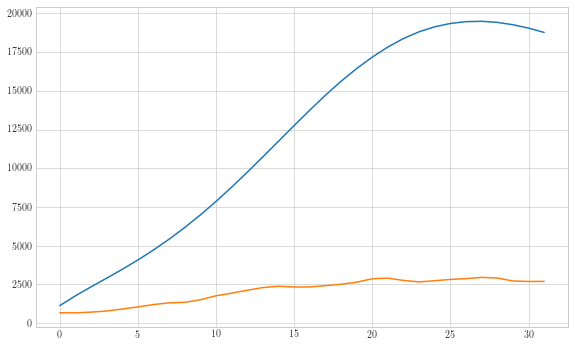

In [92]:
plt.plot(sol.y[2])
plt.plot(active_tot[2])

In [74]:
len(active_tot[2])

32